<a href="https://colab.research.google.com/github/isavic3/isavic3.github.io/blob/master/Signal_QualityRerort_20250821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You should connect your Google drive with your credintials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
pip install google.colab

#🆘 Here you should go to the folder of each recording that has the *.snirf file

In [ ]:
cd /content/drive/MyDrive/fNIRS_Laila_Iva2025/IVA

[Errno 2] No such file or directory: '/content/drive/MyDrive/fNIRS_Laila_Iva2025/IVA'
/content


You run this once... If mne and mne_nirs are installed in your kernel you don't have to run this piece again

In [ ]:
!ls

sample_data


In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.3 MB/s eta 0:00:00


# This is local

In [ ]:
import mne
import numpy as np
from itertools import compress
import matplotlib.pyplot as plt
from pathlib import Path
plt.ioff()  # keep plots from popping up
# ----------- CONFIG -------------
# This is for google colab
#folder = Path("/content/drive/MyDrive/04_Students/MSc_Students/2024_Iva_Savic/fNIRS_Laila_Iva2025/2025-05-02_001")   # <-- change to your folder

# This is for local
folder = Path("2025-05-02_001/")
snirf_file = list(folder.glob("*.snirf"))[0]
report_file = folder / "QC_report.txt"
pdf_file    = folder / "fnirs_QCreport.pdf"     # <— final multi-page PDF
# --------------------------------
# 1) Load raw SNIRF
raw_intensity = mne.io.read_raw_snirf(snirf_file, preload=True)
# 1 HH 2HL 3LH 4LL
keepers = {"1", "2", "3", "4"}

onset   = raw_intensity.annotations.onset
duration = raw_intensity.annotations.duration
desc     = raw_intensity.annotations.description

# Select only conditions 1–4
mask = np.array([d in keepers for d in desc])
onset_sel, duration_sel, desc_sel = onset[mask], duration[mask], desc[mask]

# Now keep only the first of each consecutive pair
keep_indices = []
for i, d in enumerate(desc_sel):
    if i == 0 or d != desc_sel[i-1]:
        keep_indices.append(i)

onset_final   = onset_sel[keep_indices]
duration_final = duration_sel[keep_indices]
desc_final     = desc_sel[keep_indices]

# Replace annotations with cleaned ones
raw_intensity.set_annotations(
    mne.Annotations(onset=onset_final, duration=duration_final, description=desc_final)
)

# 2) Annotations: rename, set 8 s durations, drop code '15'
raw_intensity.annotations.set_durations(8)
raw_intensity.annotations.rename({"1": "HH", "2": "HL", "3": "LH", "4": "LL"})
to_drop = np.nonzero(raw_intensity.annotations.description == "10")
raw_intensity.annotations.delete(to_drop)
to_drop = np.nonzero(raw_intensity.annotations.description == "11")
raw_intensity.annotations.delete(to_drop)

# 3) (Optional) Visual check of montage on fsaverage (see tutorial)

# 4) Keep long-sep channels (> 1 cm)
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_intensity.info, picks=picks)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=500, show_scrollbars=False
)

# 5) Intensity -> Optical Density
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

# 6) SCI QC: mark bads if desired
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots(layout="constrained")
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])
#raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.8))  # threshold per tutorial example

#I added this
bads = list(compress(raw_od.ch_names, sci < 0.8))   # <- define OD bads here
raw_od.info["bads"] = bads
bad_bases = {ch.split()[0] for ch in bads}          # <- base names like "S1_D1"

###till here


# 7) OD -> HbO/HbR (PPF example shown in the tutorial)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

# I added this
# Map OD bads to Hb-space names and drop them
#bad_chs = [f"{b} hbo" for b in bad_bases] + [f"{b} hbr" for b in bad_bases]
#bad_chs = [ch for ch in bad_chs if ch in raw_haemo.ch_names]
#if bad_chs:
  #  raw_haemo.drop_channels(bad_chs)
#till here

# 8) Filter (remove cardiac ~1 Hz, remove slow drifts)
raw_haemo = raw_haemo.filter(l_freq=0.01, h_freq=0.7)  # choose exact cutoffs per your study design

# 9) Epoch per condition
events, event_id = mne.events_from_annotations(raw_haemo)

reject_criteria = dict(hbo=30e-5)
tmin, tmax = -5, 8

epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)
epochs.plot_drop_log()

# 10) Average/visualize as needed
evoked_hbo_GR1 = epochs["HH"].average(picks="hbo")
evoked_hbr_GR1 = epochs["HH"].average(picks="hbr")
evoked_hbo_GR1 = epochs["HL"].average(picks="hbo")
evoked_hbr_GR1 = epochs["HL"].average(picks="hbr")
evoked_hbo_GR1 = epochs["LH"].average(picks="hbo")
evoked_hbr_GR1 = epochs["LH"].average(picks="hbr")
evoked_hbo_GR1 = epochs["LL"].average(picks="hbo")
evoked_hbr_GR1 = epochs["LL"].average(picks="hbr")

# ---------- Build the PDF ----------
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(pdf_file) as pdf:

    # Page 1: SCI histogram
    fig_sci, ax = plt.subplots(layout="constrained")
    ax.hist(sci, bins=20)
    ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1],
           title="SCI Distribution")
    pdf.savefig(fig_sci); plt.close(fig_sci)

    # Page 2: PSD (static alternative to interactive raw/OD browsers)
    fig_psd = raw_od.plot_psd(show=False)
    fig_psd.suptitle("Optical Density PSD", y=1.02)
    pdf.savefig(fig_psd); plt.close(fig_psd)

    # Page 3: Drop log
    fig_drop = epochs.plot_drop_log(show=False)
    fig_drop.suptitle("Epoch Drop Log", y=1.02)
    pdf.savefig(fig_drop); plt.close(fig_drop)

    # Pages 4-11: Evoked per condition (HbO & HbR)
    for cond in ["HH", "HL", "LH", "LL"]:
        if cond in epochs.event_id:
            evk_hbo = epochs[cond].average(picks="hbo")
            evk_hbr = epochs[cond].average(picks="hbr")

            fig_hbo = evk_hbo.plot(exclude=[], spatial_colors=True, show=False,
                                   titles=f"{cond} – HbO")
            pdf.savefig(fig_hbo); plt.close(fig_hbo)

            fig_hbr = evk_hbr.plot(exclude=[], spatial_colors=True, show=False,
                                   titles=f"{cond} – HbR")
            pdf.savefig(fig_hbr); plt.close(fig_hbr)

# ---------- (optional) Write a small TXT summary ----------
with open(report_file, "w", encoding="utf-8") as f:
    f.write("fNIRS QC summary\n")
    f.write(f"File: {snirf_file.name}\n")
    f.write(f"Channels (after long-sep pick): {len(raw_od.ch_names)}\n")
    f.write(f"Bad channels (SCI<0.8): {len(raw_od.info['bads'])} -> {raw_od.info['bads']}\n")
    f.write(f"SCI mean={np.mean(sci):.2f}, median={np.median(sci):.2f}\n")
    for cond in ["HH","HL","LH","LL"]:
        if cond in epochs.event_id:
            f.write(f"{cond}: {len(epochs[cond])} kept epochs\n")
    f.write("PDF saved to: " + str(pdf_file) + "\n")

print(f"✅ Saved multi-page PDF: {pdf_file}")
print(f"📝 Wrote summary: {report_file}")

ModuleNotFoundError: No module named 'mne'

# All folders

In [ ]:
#CHECK IF IT SAVED
import mne
import numpy as np
from itertools import compress
from pathlib import Path

# Optional but handy
mne.set_log_level("WARNING")

# ========= CONFIG =========
# Parent directory containing "2025-*" subfolders:
base_dir = Path("/content/drive/MyDrive/fNIRS_Laila_Iva2025/IVA")  # Colab example
#base_dir = Path(".")  # Local example

sci_threshold = 0.8
ppf_value = 0.1
low_cut, high_cut = 0.01, 0.7
tmin, tmax = -5.0, 8.0
reject_criteria = dict(hbo=30e-5)
keepers = {"1", "2", "3", "4"}      # keep only these, then rename to HH/HL/LH/LL
conditions_order = ["HH", "HL", "LH", "LL"]

# If multiple SNIRFs exist in a folder, choose how to handle:
# 'first' -> process only the first *.snirf; 'all' -> process all (rows per SNIRF combined)
FOLDER_MODE = 'first'
# ==========================


def _base_ch_name(ch_name: str) -> str:
    """Return the base (source-detector) name, stripping ' hbo'/' hbr'."""
    return ch_name.split()[0]  # e.g., "S1_D1 hbo" -> "S1_D1"


def _hemisphere_from_info(info: mne.Info, ch_name: str) -> str:
    """
    Infer hemisphere from channel x-position (in meters) if available.
    x < 0 -> Left, x > 0 -> Right, ~0 -> Midline, otherwise 'Unknown'.
    """
    try:
        idx = info.ch_names.index(ch_name)
    except ValueError:
        return "Unknown"

    loc = info["chs"][idx].get("loc", None)
    if loc is None or len(loc) < 3:
        return "Unknown"

    x = loc[0]
    if not np.isfinite(x):
        return "Unknown"
    if x < -1e-6:
        return "L"
    if x > 1e-6:
        return "R"
    return "Midline"


def _power_ratio(evoked: mne.Evoked,
                 task_window=(0.0, 8.0),
                 baseline_window=(-5.0, 0.0)) -> np.ndarray:
    """Return per-channel (task_power / baseline_power) from an Evoked."""
    t = evoked.times
    mask_task = (t >= task_window[0]) & (t <= task_window[1])
    mask_base = (t >= baseline_window[0]) & (t < baseline_window[1])

    # Mean of squared amplitude (power) over window
    data = evoked.data
    task_pwr = np.mean(data[:, mask_task] ** 2, axis=1)
    base_pwr = np.mean(data[:, mask_base] ** 2, axis=1)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = task_pwr / base_pwr
    ratio[~np.isfinite(ratio) | (base_pwr == 0)] = np.nan
    return ratio

#this is my code on request: relative power-ratio

def _power_rel_change(evoked, post_window=(0.0, 8.0), base_window=(-5.0, 0.0), eps=1e-12):
    """
    (Mean power post − mean power pre) / mean power pre, per channel.
    Power = mean(signal^2) in the window. Returns 1D array (n_channels,).
    """
    t = evoked.times
    mask_post = (t >= post_window[0]) & (t <= post_window[1])
    mask_base = (t >= base_window[0]) & (t <  base_window[1])  # non-overlap

    data = evoked.data
    post_pwr = np.mean(data[:, mask_post] ** 2, axis=1)
    base_pwr = np.mean(data[:, mask_base] ** 2, axis=1)

    denom = np.maximum(base_pwr, eps)     # avoid div-by-zero explosions
    rel = (post_pwr - base_pwr) / denom   # == post/base - 1
    rel[~np.isfinite(rel)] = np.nan
    rel[base_pwr < eps] = np.nan
    return rel

def _peak_and_latency(evoked, post_window=(0.0, 8.0)):
    """
    Signed peak amplitude and its latency (s) in the post window, per channel.
    Returns (peak_amp, peak_latency) as 1D arrays.
    """
    t = evoked.times
    mask = (t >= post_window[0]) & (t <= post_window[1])
    seg = evoked.data[:, mask]
    t_seg = t[mask]

    if seg.size == 0:
        n = evoked.data.shape[0]
        return np.full(n, np.nan), np.full(n, np.nan)

    idx = np.argmax(np.abs(seg), axis=1)   # location of max |amp|
    rows = np.arange(seg.shape[0])

    peak_amp = seg[rows, idx]              # signed peak
    peak_lat = t_seg[idx]                  # seconds
    return peak_amp, peak_lat
#till here


def _process_one_snirf(folder: Path, snirf_path: Path):
    """
    Load one SNIRF, mark bads via SCI, convert to HbO/HbR, epoch, then
    compute normalized power (task/baseline) per good channel & condition.
    Returns a list of rows: [Folder, ChannelBase, Norm_HbO, Norm_HbR, Condition, Hemisphere]
    """
    rows = []

    # 1) Load intensity
    raw_intensity = mne.io.read_raw_snirf(snirf_path, preload=True)

    # --- Clean annotations to keep only 1,2,3,4 and drop consecutive duplicates ---
    ann = raw_intensity.annotations
    mask = np.array([d in keepers for d in ann.description])
    onset_sel, duration_sel, desc_sel = ann.onset[mask], ann.duration[mask], ann.description[mask]

    keep_idx = []
    for i, d in enumerate(desc_sel):
        if i == 0 or d != desc_sel[i - 1]:
            keep_idx.append(i)

    raw_intensity.set_annotations(
        mne.Annotations(onset=onset_sel[keep_idx],
                        duration=duration_sel[keep_idx],
                        description=desc_sel[keep_idx])
    )

    # 2) Rename to HH/HL/LH/LL, enforce 8 s durations, drop 10/11 if present
    raw_intensity.annotations.set_durations(8.0)
    raw_intensity.annotations.rename({"1": "HH", "2": "HL", "3": "LH", "4": "LL"})
    for drop_code in ("10", "11"):
        idx = np.nonzero(raw_intensity.annotations.description == drop_code)
        if len(idx[0]) > 0:
            raw_intensity.annotations.delete(idx)

    # 4) Keep long-sep channels (> 1 cm)
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(raw_intensity.info, picks=picks)
    raw_intensity.pick(picks[dists > 0.01])

    # 5) -> Optical Density
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    # 6) SCI -> bad channels
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    bads = list(compress(raw_od.ch_names, sci < sci_threshold))
    raw_od.info["bads"] = bads

    # Map bad OD channels (e.g., "S1_D1 760"/"S1_D1 850") to base names ("S1_D1")
    bad_bases = {ch.split()[0] for ch in bads}

    # 7) -> HbO/HbR
    raw_hb = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=ppf_value)

    # --- Drop bad channels in Hb space so evokeds only contain GOOD channels ---
    hb_bad = [f"{b} hbo" for b in bad_bases] + [f"{b} hbr" for b in bad_bases]
    hb_bad = [ch for ch in hb_bad if ch in raw_hb.ch_names]  # keep only existing
    if hb_bad:
        raw_hb.drop_channels(hb_bad)  # remove them entirely
        raw_haemo = raw_hb #Iva's upgrade: I added this  line. so i use it for future code

    # 8) Filter
    raw_hb = raw_hb.filter(l_freq=low_cut, h_freq=high_cut)

    # 9) Epochs
    events, event_id = mne.events_from_annotations(raw_hb)
    epochs = mne.Epochs(
        raw_hb,
        events,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        reject=reject_criteria,
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        preload=True,
        detrend=None,
        verbose=False,
    )

# here iva #ed because i write slightly adjusted version bellow

    # For each condition present, compute evoked averages, then normalized power
   # present_conditions = [c for c in conditions_order if c in epochs.event_id]

    #for cond in present_conditions:
        # Evoked per hemoglobin type (bad channels are excluded by default)
  #      evk_hbo = epochs[cond].average(picks="hbo")
  #      evk_hbr = epochs[cond].average(picks="hbr")

        # Per-channel normalized power
   #     ratio_hbo = _power_ratio(evk_hbo, task_window=(0, 8), baseline_window=(-5, 0))
    #    ratio_hbr = _power_ratio(evk_hbr, task_window=(0, 8), baseline_window=(-5, 0))

        # Align HbO/HbR by base channel name (e.g., "S1_D1")
   #     bases_hbo = {_base_ch_name(ch): i for i, ch in enumerate(evk_hbo.ch_names)}
   #     bases_hbr = {_base_ch_name(ch): i for i, ch in enumerate(evk_hbr.ch_names)}
    #    shared_bases = sorted(set(bases_hbo) & set(bases_hbr))

     #   for base in shared_bases:
      #      i_hbo = bases_hbo[base]
       #     i_hbr = bases_hbr[base]

         #   ch_name_hbo = evk_hbo.ch_names[i_hbo]  # e.g., "S1_D1 hbo"
         #   hemi = _hemisphere_from_info(evk_hbo.info, ch_name_hbo)

          #  norm_hbo = float(ratio_hbo[i_hbo])
           # norm_hbr = float(ratio_hbr[i_hbr])

           # rows.append([
            #    folder.name,     # Folder
            #    base,            # Channel (base S#_D#)
             #   norm_hbo,        # Normalized HbO power
             #   norm_hbr,        # Normalized HbR power
               # cond,            # Condition
               # hemi,            # Hemisphere
           # ])

   # return rows

# iva's code to adjust the one above I hasthtgged
# For each condition present, compute evoked averages, then per-channel metrics
present_conditions = [c for c in conditions_order if c in epochs.event_id]

for cond in present_conditions:
    # Evoked per hemoglobin type (bad channels already dropped upstream)
    evk_hbo = epochs[cond].average(picks="hbo")
    evk_hbr = epochs[cond].average(picks="hbr")

    # (1) Relative power change
    relpow_hbo = _power_rel_change(evk_hbo, post_window=(0, 8), base_window=(-5, 0))
    relpow_hbr = _power_rel_change(evk_hbr, post_window=(0, 8), base_window=(-5, 0))

    # (2) Peak amplitude & (3) latency
    peak_hbo, lat_hbo = _peak_and_latency(evk_hbo, post_window=(0, 8))
    peak_hbr, lat_hbr = _peak_and_latency(evk_hbr, post_window=(0, 8))

    # Align HbO/HbR by base channel name (e.g., "S1_D1")
    bases_hbo = {_base_ch_name(ch): i for i, ch in enumerate(evk_hbo.ch_names)}
    bases_hbr = {_base_ch_name(ch): i for i, ch in enumerate(evk_hbr.ch_names)}
    shared_bases = sorted(set(bases_hbo) & set(bases_hbr))

    for base in shared_bases:
        i_o = bases_hbo[base]
        i_r = bases_hbr[base]

        ch_name_hbo = evk_hbo.ch_names[i_o]  # e.g., "S1_D1 hbo"
        hemi = _hemisphere_from_info(evk_hbo.info, ch_name_hbo)

        rows.append([
            folder.name,           # Folder / subject/run
            base,                  # Channel base (S#_D#)
            float(relpow_hbo[i_o]),
            float(relpow_hbr[i_r]),
            float(peak_hbo[i_o]),
            float(peak_hbr[i_r]),
            float(lat_hbo[i_o]),
            float(lat_hbr[i_r]),
            cond,                  # Condition
            hemi,                  # Hemisphere
        ])
#till here

# same here iva #ed all to adjust

#def build_normalized_power_matrix(root: Path):
    """
    Walk all '2025-*' folders and compute rows for each folder.
    Returns a list-of-lists and, if pandas is available, a DataFrame.
    """
   # folders = sorted([p for p in root.iterdir() if p.is_dir() and p.name.startswith("2025-")])
    #all_rows = []

  #  for folder in folders:
   #     snirfs = sorted(folder.glob("*.snirf"))
      #  if not snirfs:
        #    print(f"— {folder.name}: no *.snirf files found")
        #    continue

       # if FOLDER_MODE == 'first':
          #snirfs = [snirfs[0]]

       # for snf in snirfs:
          #  try:
            #    rows = _process_one_snirf(folder, snf)
             #   all_rows.extend(rows)
             #   print(f"✅ {folder.name} | {snf.name}: {len(rows)} rows")
           # except Exception as e:
             #   print(f"❌ {folder.name} | {snf.name}: {e}")

    # Try to return a DataFrame too
  #  try:
   #     import pandas as pd
    #    df = pd.DataFrame(
     #       all_rows,
      #      columns=["Folder", "Channel", "Norm_HbO_Power", "Norm_HbR_Power", "Condition", "Hemisphere"]
       # )
       # out_csv = root / "normalized_power_matrix.csv"
       # df.to_csv(out_csv, index=False)
       # print(f"\nSaved CSV: {out_csv}  (rows={len(df)})")
       # return all_rows, df
   # except Exception:
       # return all_rows, None

# iva's code instead above

def build_normalized_power_matrix(root: Path):
    """
    Walk all '2025-*' folders and compute rows for each folder.
    Returns (all_rows, df) where df has columns:
      Folder, Channel, RelPow_HbO, RelPow_HbR, Peak_HbO, Peak_HbR,
      Lat_HbO, Lat_HbR, Condition, Hemisphere
    """
    folders = sorted([p for p in root.iterdir() if p.is_dir() and p.name.startswith("2025-")])
    all_rows = []

    for folder in folders:
        snirfs = sorted(folder.glob("*.snirf"))
        if not snirfs:
            print(f"— {folder.name}: no *.snirf files found")
            continue

        if FOLDER_MODE == 'first':
            snirfs = [snirfs[0]]

        for snf in snirfs:
            try:
                rows = _process_one_snirf(folder, snf)
                all_rows.extend(rows)
                print(f"✅ {folder.name} | {snf.name}: {len(rows)} rows")
            except Exception as e:
                print(f"❌ {folder.name} | {snf.name}: {e}")

    # Build one DataFrame with the NEW columns and save CSV
    try:
        import pandas as pd
        df = pd.DataFrame(
            all_rows,
            columns=[
                "Folder", "Channel",
                "RelPow_HbO", "RelPow_HbR",
                "Peak_HbO", "Peak_HbR",
                "Lat_HbO", "Lat_HbR",
                "Condition", "Hemisphere",
            ],
        )
        out_csv = root / "channel_metrics_matrix.csv"
        df.to_csv(out_csv, index=False)
        print(f"\nSaved CSV: {out_csv}  (rows={len(df)})")
        return all_rows, df
    except Exception as e:
        print("CSV/DF creation failed:", e)
        return all_rows, None
#till here



# ==== Run ====
rows, df = build_normalized_power_matrix(base_dir)

# Optional: show a quick peek if DataFrame is available
if df is not None:
    try:
        from IPython.display import display
        display(df.head())
    except Exception:
        print(rows[:5])


NameError: name 'epochs' is not defined

In [ ]:
pip install -U mne mne-nirs

# Statistical Analysis

In [ ]:
# === fNIRS stats: z-filter, Shapiro matrices, RM-ANOVA with FDR, and topoplots ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.anova import AnovaRM
import mne
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
conditions_order = ["HH", "HL", "LH", "LL"]   # column order for Shapiro matrices
hem_levels = ["L", "R"]                       # enforce these for ANOVA

# Provide either an in-memory df in your session, or load from CSV path below:
df_path = None  # e.g., Path("normalized_power_matrix.csv")

# Parent with SNIRF folders (for pulling coords from raw_haemo)
base_dir_for_coords = Path(".")
out_dir = Path("stats_output")
out_dir.mkdir(exist_ok=True, parents=True)

mne.set_log_level("WARNING")

#iva's code
COL_HBO = "RelPow_HbO"
COL_HBR = "RelPow_HbR"
# till here
# -----------------------------
# OUTLIER FILTER (per Channel×Condition)
# -----------------------------
#def clean_and_zfilter(df):
 #   df = df.copy()
    # Keep only two-hemisphere rows for ANOVA consistency
  #  df = df[df["Hemisphere"].isin(hem_levels)]

   # def zf(g):
        # compute z-scores manually to handle constant groups
    #    def z_of(col):
     #       mu = g[col].mean()
      #      sd = g[col].std(ddof=0)
       #     if not np.isfinite(sd) or sd == 0:
        #        return pd.Series(np.nan, index=g.index)
         #   return (g[col] - mu) / sd

     #   g["z_hbo"] = z_of("Norm_HbO_Power")
      #  g["z_hbr"] = z_of("Norm_HbR_Power")
     #   keep = g["z_hbo"].abs().le(3) & g["z_hbr"].abs().le(3)
      #  return g.loc[keep].drop(columns=["z_hbo", "z_hbr"])

   # return df.groupby(["Channel", "Condition"], group_keys=False).apply(zf)

#iva's code instead of above
def clean_and_zfilter(df):
    df = df.copy()
    df = df[df["Hemisphere"].isin(hem_levels)]

    def zf(g):
        def z_of(col):
            mu = g[col].mean()
            sd = g[col].std(ddof=0)
            if not np.isfinite(sd) or sd == 0:
                return pd.Series(np.nan, index=g.index)
            return (g[col] - mu) / sd

        g["z_hbo"] = z_of(COL_HBO)
        g["z_hbr"] = z_of(COL_HBR)
        keep = g["z_hbo"].abs().le(3) & g["z_hbr"].abs().le(3)
        return g.loc[keep].drop(columns=["z_hbo", "z_hbr"])

    return df.groupby(["Channel", "Condition"], group_keys=False).apply(zf)
#ends here

# -----------------------------
# SHAPIRO MATRICES
# -----------------------------
def shapiro_by_channel_condition(df, value_col):
    chans = sorted(df["Channel"].unique())
    W = np.full((len(chans), len(conditions_order)), np.nan)
    P = np.full_like(W, np.nan, dtype=float)
    N = np.full_like(W, np.nan, dtype=float)
    for i, ch in enumerate(chans):
        for j, cond in enumerate(conditions_order):
            vals = df.loc[(df["Channel"]==ch)&(df["Condition"]==cond), value_col].dropna().values
            n = len(vals)
            N[i, j] = n
            if n >= 3:
                W[i, j], P[i, j] = shapiro(vals)
    return chans, W, P, N

def save_matrix(M, rows, cols, path):
    pd.DataFrame(M, index=rows, columns=cols).to_csv(path, index=True)

# -----------------------------
# ANOVA HELPERS
# -----------------------------
def add_va(df):
    df = df.copy()
    df["Valence"] = df["Condition"].str[0]
    df["Arousal"] = df["Condition"].str[1]
    return df

def make_rm_data(df, value_col):
    """
    Aggregate to one value per Subject(Folder) × Hemisphere × Valence × Arousal (mean across channels).
    Keep only subjects that have all 8 cells populated.
    """
    df = add_va(df)
    agg = (df.groupby(["Folder","Hemisphere","Valence","Arousal"], as_index=False)[value_col]
             .mean())
    needed = len(hem_levels)*2*2  # 8 cells
    ok = agg.groupby("Folder").size()
    keep_subjects = ok[ok==needed].index
    return agg[agg["Folder"].isin(keep_subjects)].copy(), keep_subjects

def run_anovarm(df_long, value_col):
    df_long = df_long.copy()
    df_long["Hemisphere"] = pd.Categorical(df_long["Hemisphere"], categories=hem_levels, ordered=True)
    df_long["Valence"]    = pd.Categorical(df_long["Valence"],    categories=["L","H"], ordered=True)
    df_long["Arousal"]    = pd.Categorical(df_long["Arousal"],    categories=["L","H"], ordered=True)
    aov = AnovaRM(df_long, depvar=value_col, subject="Folder",
                  within=["Hemisphere","Valence","Arousal"]).fit()
    tbl = aov.anova_table.loc[
        ["Hemisphere","Valence","Arousal",
         "Hemisphere:Valence","Hemisphere:Arousal","Valence:Arousal",
         "Hemisphere:Valence:Arousal"],
        ["F Value","Num DF","Den DF","Pr > F"]
    ].rename(columns={"F Value":"F","Num DF":"df1","Den DF":"df2","Pr > F":"p"}).copy()
    rej, p_fdr = fdrcorrection(tbl["p"].values)
    tbl["p_FDR"] = p_fdr
    tbl["sig_FDR"] = rej
    return tbl

# -----------------------------
# EFFECT MAPS PER CHANNEL (mean contrasts across subjects)
# -----------------------------
def effect_map(df, value_col, effect):
    """
    Return dict {ChannelBase -> effect_value} for a main effect or interaction.
    effect ∈ {"Hemisphere","Valence","Arousal",
              "Hemisphere:Valence","Hemisphere:Arousal","Valence:Arousal",
              "Hemisphere:Valence:Arousal"}
    """
    tmp = add_va(df.copy())

    if effect == "Hemisphere":
        g = (tmp.groupby(["Folder","Channel","Hemisphere"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns="Hemisphere", values=value_col)
        if not set(hem_levels).issubset(piv.columns): return {}
        diff = (piv["R"] - piv["L"]).groupby("Channel").mean()
        return diff.to_dict()

    if effect == "Valence":
        g = (tmp.groupby(["Folder","Channel","Valence"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns="Valence", values=value_col)
        if not {"H","L"}.issubset(piv.columns): return {}
        diff = (piv["H"] - piv["L"]).groupby("Channel").mean()
        return diff.to_dict()

    if effect == "Arousal":
        g = (tmp.groupby(["Folder","Channel","Arousal"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns="Arousal", values=value_col)
        if not {"H","L"}.issubset(piv.columns): return {}
        diff = (piv["H"] - piv["L"]).groupby("Channel").mean()
        return diff.to_dict()

    # interactions (difference-of-differences)
    if effect == "Valence:Arousal":
        g = (tmp.groupby(["Folder","Channel","Valence","Arousal"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns=["Valence","Arousal"], values=value_col)
        need = {("H","H"),("H","L"),("L","H"),("L","L")}
        if not need.issubset(set(piv.columns)): return {}
        dd = (piv[("H","H")] - piv[("H","L")]) - (piv[("L","H")] - piv[("L","L")])
        return dd.groupby("Channel").mean().to_dict()

    if effect == "Hemisphere:Valence":
        g = (tmp.groupby(["Folder","Channel","Hemisphere","Valence"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns=["Hemisphere","Valence"], values=value_col)
        need = {(h,v) for h in hem_levels for v in ["H","L"]}
        if not need.issubset(set(piv.columns)): return {}
        dd = (piv[("R","H")] - piv[("L","H")]) - (piv[("R","L")] - piv[("L","L")])
        return dd.groupby("Channel").mean().to_dict()

    if effect == "Hemisphere:Arousal":
        g = (tmp.groupby(["Folder","Channel","Hemisphere","Arousal"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns=["Hemisphere","Arousal"], values=value_col)
        need = {(h,a) for h in hem_levels for a in ["H","L"]}
        if not need.issubset(set(piv.columns)): return {}
        dd = (piv[("R","H")] - piv[("L","H")]) - (piv[("R","L")] - piv[("L","L")])
        return dd.groupby("Channel").mean().to_dict()

    if effect == "Hemisphere:Valence:Arousal":
        g = (tmp.groupby(["Folder","Channel","Hemisphere","Valence","Arousal"], as_index=False)[value_col].mean())
        piv = g.pivot_table(index=["Folder","Channel"], columns=["Hemisphere","Valence","Arousal"], values=value_col)
        need = {(h,v,a) for h in hem_levels for v in ["H","L"] for a in ["H","L"]}
        if not need.issubset(set(piv.columns)): return {}
        dva_R = (piv[("R","H","H")] - piv[("R","H","L")]) - (piv[("R","L","H")] - piv[("R","L","L")])
        dva_L = (piv[("L","H","H")] - piv[("L","H","L")]) - (piv[("L","L","H")] - piv[("L","L","L")])
        dd = dva_R - dva_L
        return dd.groupby("Channel").mean().to_dict()

    return {}

# -----------------------------
# BUILD TEMPLATE INFO (coords) FROM A SNIRF
# -----------------------------
def find_template_snirf(base_dir: Path):
    for folder in sorted([p for p in base_dir.iterdir() if p.is_dir() and p.name.startswith("2025-")]):
        snirfs = sorted(folder.glob("*.snirf"))
        if snirfs:
            return snirfs[0]
    return None

def build_template_info_from_snirf(snirf_path: Path):
    """Return info for HbO/HbR channels after long-separation pick (>=1 cm)."""
    raw_intensity = mne.io.read_raw_snirf(snirf_path, preload=False)
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(raw_intensity.info, picks=picks)
    raw_intensity.pick(picks[dists > 0.01])  # keep long sep (>1 cm)
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
    raw_hb = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
    return raw_hb.info  # channel names like "... hbo"/"... hbr" with positions in chs[].loc

# -----------------------------
# TOPO PLOTTING (fallback using plot_topomap)
# -----------------------------
def _pos2d_from_info(info: mne.Info, ch_names_ordered):
    """Get 2D positions for given channel names and normalize to head circle."""
    picks = mne.pick_channels(info["ch_names"], ch_names_ordered, ordered=True)
    if len(picks) == 0:
        return None, []
    locs3d = np.array([info["chs"][pi]["loc"][:3] for pi in picks])  # (n, 3)
    # Sometimes loc can be zeros/nans; handle robustly
    if not np.isfinite(locs3d).all():
        # fall back to zeros to avoid crash
        locs3d = np.nan_to_num(locs3d, nan=0.0)
    pos = locs3d[:, :2]  # use x,y as 2D
    # center & scale to roughly fit the head outline circle
    pos = pos - pos.mean(axis=0, keepdims=True)
    rad = np.linalg.norm(pos, axis=1).max()
    if not np.isfinite(rad) or rad == 0:
        rad = 1.0
    pos = pos / (rad * 1.05)
    ordered_names = [info["ch_names"][pi] for pi in picks]
    return pos, ordered_names

def save_nirs_topomap_from_effect(effect_by_base: dict, ch_type: str,
                                  title: str, outpath, template_info: mne.Info):
    """
    Plot a 'topomap' for fNIRS using plot_topomap:
      effect_by_base: {"S1_D1": value, ...}
      ch_type: "hbo" or "hbr"
    """
    if not effect_by_base:
        return False
    wanted = [f"{base} {ch_type}" for base in effect_by_base.keys()]
    present = [ch for ch in wanted if ch in template_info["ch_names"]]
    if not present:
        return False

    pos2d, ordered = _pos2d_from_info(template_info, present)
    if pos2d is None or len(ordered) == 0:
        return False

    vals = np.array([effect_by_base[ch.split()[0]] for ch in ordered], float)

    fig, ax = plt.subplots(figsize=(5, 5))
    # You can pass names for debugging/annotation; not required
    im, cn = mne.viz.plot_topomap(vals, pos2d, axes=ax, show=False, outlines="head")
    ax.set_title(title)
    fig.savefig(outpath, dpi=150, bbox_inches="tight")
    plt.close(fig)
    return True

# -----------------------------
# MAIN ENTRY
# -----------------------------
# i slightly added the exisitng code (naming COL_HB0) and also added per channel ANOVA
def analyze_normalized_df(df=None, base_dir_for_coords: Path = base_dir_for_coords):
    # 1) Load df if needed
    if df is None and df_path is not None:
        df_local = pd.read_csv(df_path)
    elif df is not None:
        df_local = df.copy()
    else:
        raise ValueError("Provide in-memory `df` or set `df_path` to a CSV with the normalized matrix.")

    # 2) Clean + outlier removal
    df_clean = clean_and_zfilter(df_local)

    # 3) Shapiro–Wilk per Channel×Condition (HbO & HbR)
    ch_hbo, W_hbo, P_hbo, N_hbo = shapiro_by_channel_condition(df_clean, COL_HBO)
    ch_hbr, W_hbr, P_hbr, N_hbr = shapiro_by_channel_condition(df_clean, COL_HBR)
    save_matrix(W_hbo, ch_hbo, conditions_order, out_dir/"shapiro_W_HbO.csv")
    save_matrix(P_hbo, ch_hbo, conditions_order, out_dir/"shapiro_p_HbO.csv")
    save_matrix(N_hbo, ch_hbo, conditions_order, out_dir/"shapiro_n_HbO.csv")
    save_matrix(W_hbr, ch_hbr, conditions_order, out_dir/"shapiro_W_HbR.csv")
    save_matrix(P_hbr, ch_hbr, conditions_order, out_dir/"shapiro_p_HbR.csv")
    save_matrix(N_hbr, ch_hbr, conditions_order, out_dir/"shapiro_n_HbR.csv")

        # 4) RM-ANOVA on subject means (3-way Hemisphere×Valence×Arousal) + FDR within-table
    def run_and_save(value_col, tag):
        long_df, kept = make_rm_data(df_clean, value_col)
        aov = run_anovarm(long_df, value_col)
        aov.to_csv(out_dir/f"anova_rm_{tag}.csv")
        return aov, kept
    aov_hbo, kept_hbo = run_and_save(COL_HBO, "HbO")
    aov_hbr, kept_hbr = run_and_save(COL_HBR, "HbR")

    # 4b) Per-channel 2×2 (Valence×Arousal) RM-ANOVAs with FDR across channels
    try:
        per_ch_hbo = per_channel_anovas(df_clean, COL_HBO)
        per_ch_hbo.to_csv(out_dir/"per_channel_anova_HbO.csv", index=False)
        print(f"Saved per-channel ANOVAs (HbO): {len(per_ch_hbo)} channels")
    except Exception as e:
        print("Per-channel ANOVAs (HbO) failed:", e)
        per_ch_hbo = pd.DataFrame()

    try:
        per_ch_hbr = per_channel_anovas(df_clean, COL_HBR)
        per_ch_hbr.to_csv(out_dir/"per_channel_anova_HbR.csv", index=False)
        print(f"Saved per-channel ANOVAs (HbR): {len(per_ch_hbr)} channels")
    except Exception as e:
        print("Per-channel ANOVAs (HbR) failed:", e)
        per_ch_hbr = pd.DataFrame()

    # 4c) STACK and save one combined CSV (HbO+HbR)  <-- THIS is the right place
    try:
        stacks = []
        if not per_ch_hbo.empty:
            t = per_ch_hbo.copy(); t["Hemo"] = "HbO"; stacks.append(t)
        if not per_ch_hbr.empty:
            t = per_ch_hbr.copy(); t["Hemo"] = "HbR"; stacks.append(t)
        if stacks:
            pd.concat(stacks, ignore_index=True).to_csv(out_dir / "per_channel_anova_ALL.csv", index=False)
    except Exception as e:
        print("Could not save stacked per-channel ANOVAs:", e)

    # 5) Topoplots, using the same metric columns
    topo_notes = []
    template_snirf = find_template_snirf(base_dir_for_coords)
    if template_snirf is None:
        topo_notes.append("Topoplots skipped: no SNIRF found under base_dir_for_coords.")
        template_info = None
    else:
        template_info = build_template_info_from_snirf(template_snirf)

    def make_topos_for_effect(effect_name):
        if template_info is None:
            return
        sig_any = False
        if effect_name in aov_hbo.index and bool(aov_hbo.loc[effect_name, "sig_FDR"]):
            sig_any = True
        if effect_name in aov_hbr.index and bool(aov_hbr.loc[effect_name, "sig_FDR"]):
            sig_any = True
        if not sig_any:
            return
        eff_map_o = effect_map(df_clean, COL_HBO, effect_name)
        ok_o = save_nirs_topomap_from_effect(
            eff_map_o, "hbo", f"HbO {effect_name}", out_dir/f"topo_HbO_{effect_name}.png", template_info
        )
        topo_notes.append(f"HbO {effect_name}: {'saved' if ok_o else 'skipped'}")

        eff_map_r = effect_map(df_clean, COL_HBR, effect_name)
        ok_r = save_nirs_topomap_from_effect(
            eff_map_r, "hbr", f"HbR {effect_name}", out_dir/f"topo_HbR_{effect_name}.png", template_info
        )
        topo_notes.append(f"HbR {effect_name}: {'saved' if ok_r else 'skipped'}")

    for eff in ["Hemisphere","Valence","Arousal",
                "Hemisphere:Valence","Hemisphere:Arousal","Valence:Arousal",
                "Hemisphere:Valence:Arousal"]:
        make_topos_for_effect(eff)

    # 6) Report (add per-channel summary)  <-- build report AFTER the stacked CSV
    report = []
    report.append("# RM-ANOVA Report (HbO & HbR)")
    report.append(f"- Input rows: {len(df_local)}")
    report.append(f"- After z-filter: {len(df_clean)}")
    report.append(f"- Balanced subjects kept  HbO: {len(kept_hbo)} | HbR: {len(kept_hbr)}")
    report.append("")
    report.append("## Shapiro–Wilk matrices saved")
    report.append("- HbO: shapiro_W_HbO.csv, shapiro_p_HbO.csv, shapiro_n_HbO.csv")
    report.append("- HbR: shapiro_W_HbR.csv, shapiro_p_HbR.csv, shapiro_n_HbR.csv")
    report.append("")
    report.append("## Repeated-measures ANOVA on subject means (F, df1, df2, p, p_FDR, sig_FDR)")
    report.append("### HbO")
    report.append(pd.read_csv(out_dir/"anova_rm_HbO.csv", index_col=0).to_string())
    report.append("")
    report.append("### HbR")
    report.append(pd.read_csv(out_dir/"anova_rm_HbR.csv", index_col=0).to_string())
    report.append("")

    # Per-channel summary
    def _sigline(dfpc, label):
        if dfpc.empty:
            return f"- {label}: no channels analyzed."
        nV  = int(dfpc.get("sig_Valence", pd.Series(dtype=bool)).sum())
        nA  = int(dfpc.get("sig_Arousal", pd.Series(dtype=bool)).sum())
        nVA = int(dfpc.get("sig_Valence:Arousal", pd.Series(dtype=bool)).sum())
        return f"- {label}: sig(FDR) — Valence={nV}, Arousal={nA}, V×A={nVA}"

    report.append("## Per-channel ANOVAs (2×2; FDR across channels)")
    report.append(_sigline(per_ch_hbo, "HbO"))
    report.append(_sigline(per_ch_hbr, "HbR"))
    report.append("")

    if template_snirf is None:
        report.append("## Topoplots")
        report.append("- Skipped (no SNIRF found for coordinates).")
    else:
        report.append(f"## Topoplots (coords from: {template_snirf.name})")
        for note in topo_notes:
            report.append(f"- {note}")

    (out_dir/"report.txt").write_text("\n".join(report), encoding="utf-8")
    print(f"Saved Shapiro matrices, ANOVA tables, per-channel ANOVAs, topoplots, and report to: {out_dir.resolve()}")


    return {
        "ANOVA_HbO": aov_hbo, "ANOVA_HbR": aov_hbr,
        "per_channel_HbO": per_ch_hbo, "per_channel_HbR": per_ch_hbr,
        "clean_df": df_clean, "template_snirf": template_snirf
    }





/tmp/ipython-input-4207396529.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["Channel", "Condition"], group_keys=False).apply(zf)


Saved Shapiro matrices, ANOVA tables, topoplots, and report to: /content/drive/MyDrive/fNIRS_Laila_Iva2025/IVA/stats_output


In [ ]:
from mne_nirs.channels import get_long_channels

long  = get_long_channels(raw_haemo)
long.annotations

<Annotations | 59 segments: HH (16), HL (11), LH (16), LL (16)>

In [ ]:
## GLM FIT (robust, version-proof)

# --- 0) Setup ---
# !pip install mne mne-nirs nilearn pandas numpy
import numpy as np, pandas as pd, mne
from mne_nirs.channels import get_long_channels
from nilearn.glm.contrasts import expression_to_contrast_vector
from nilearn.glm.first_level import make_first_level_design_matrix

# Use your precomputed haemoglobin Raw:
long = get_long_channels(raw_haemo.drop_channels(bad_chs))   # HbO/HbR long-separation channels

# ---------- Events from annotations (labels are already HH/HL/LH/LL) ----------
VALID = {"HH", "HL", "LH", "LL"}

def canon_label(s: str):
    s = "".join(ch for ch in str(s).strip().upper() if ch.isalpha())
    return s if s in VALID else None

sfreq = long.info["sfreq"]
event_list = []

for onset, duration, desc in zip(long.annotations.onset,
                                 long.annotations.duration,
                                 long.annotations.description):
    lab = canon_label(desc)
    if lab is not None:
        onset_sample = int(round(float(onset) * sfreq))
        event_list.append([onset_sample, 0, lab])  # keep label for now

if not event_list:
    raise RuntimeError("No HH/HL/LH/LL annotations found in `long.annotations`.")

# map labels -> integer event codes for MNE Epochs
event_id = {"HH": 1, "HL": 2, "LH": 3, "LL": 4}
label_to_code = event_id
code_to_label = {v: k for k, v in event_id.items()}

# build MNE events array (n_events × 3) with integer codes
events = np.array([[samp, 0, label_to_code[lab]] for samp, _, lab in event_list], dtype=int)
events = events[np.argsort(events[:, 0])]  # sort by onset sample

# ---------- QC epochs (unchanged) ----------
tmin, tmax = -5.0, 8.0
picks = mne.pick_types(long.info, fnirs=True)

epochs = mne.Epochs(
    long, events, event_id=event_id, tmin=tmin, tmax=tmax,
    picks=picks, baseline=(tmin, 0.0), preload=True, reject_by_annotation=True,
    detrend=None,
)

Xep = epochs.get_data()  # (n_epochs, n_channels, n_times)

def robust_z(x, axis=None, eps=1e-12):
    med = np.nanmedian(x, axis=axis, keepdims=True)
    mad = np.nanmedian(np.abs(x - med), axis=axis, keepdims=True) + eps
    return (x - med) / (1.4826 * mad)

p2p = Xep.max(axis=-1) - Xep.min(axis=-1)
p2p_epoch = p2p.max(axis=1)
p2p_z = robust_z(p2p_epoch, axis=0).ravel()

dX = np.diff(Xep, axis=-1)
dstd = np.nanstd(dX, axis=-1)
dstd_epoch = dstd.max(axis=1)
dstd_z = robust_z(dstd_epoch, axis=0).ravel()

var_ch = np.nanvar(Xep, axis=-1)
min_var_epoch = var_ch.min(axis=1)
flat_z = -robust_z(min_var_epoch, axis=0).ravel()

z_thresh = 4.0
is_bad = (np.abs(p2p_z) > z_thresh) | (np.abs(dstd_z) > z_thresh) | (flat_z > z_thresh)
good_idx = np.where(~is_bad)[0]

print(f"QC: kept {len(good_idx)}/{len(epochs)} epochs "
      f"(drop {is_bad.sum()} for P2P/derivative/flatline)")
print("Median z (kept):",
      f"P2P={np.median(p2p_z[~is_bad]):.2f}, dSTD={np.median(dstd_z[~is_bad]):.2f}, FLAT={np.median(flat_z[~is_bad]):.2f}")

# ---------- Filtered events_df for GLM (labels from codes) ----------
kept_events = events[good_idx]
kept_onsets_sec = kept_events[:, 0] / sfreq
kept_labels = [code_to_label[c] for c in kept_events[:, 2]]

#stim_dur = 1.0  # set your true duration if known
stim_dur = 8.0  # set your true duration if known  #iva change ot 8
events_df = pd.DataFrame({
    "trial_type": kept_labels,
    "onset": kept_onsets_sec,
    "duration": [stim_dur] * len(kept_labels),
})

# ---------- Design matrix (Nilearn) ----------
nuisance = {}
frame_times = long.times  # seconds

dm = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events_df,
    drift_model="cosine",
    high_pass=0.01,
    hrf_model="spm"  # or "spm + derivative" if you want timing robustness
)
print("DM columns:", list(dm.columns))

# ---------- GLM (matrix OLS; version-proof) ----------
Y = long.get_data().T
X = np.asarray(dm.values, dtype=float)
n, p = X.shape
XtX = X.T @ X
XtX_inv = np.linalg.pinv(XtX)
B = XtX_inv @ (X.T @ Y)           # p × n_channels
E = Y - X @ B
dof = max(n - p, 1)
sigma2 = (E**2).sum(axis=0) / dof  # per-channel

# ---------- Betas (+SE) for HH/HL/LH/LL ----------
canonical = [c for c in ["HH", "HL", "LH", "LL"] if c in dm.columns]
reg_idx = [dm.columns.get_loc(c) for c in canonical]
diag_XtX_inv = np.diag(XtX_inv)

rows = []
for j, ch in enumerate(long.ch_names):
    for name, ridx in zip(canonical, reg_idx):
        beta = float(B[ridx, j])
        se = float(np.sqrt(sigma2[j] * max(diag_XtX_inv[ridx], 0.0)))
        rows.append({"channel": ch, "regressor": name, "beta": beta, "se": se})
betas_df = pd.DataFrame(rows)

# ---------- 2×2 contrasts ----------
#contrast_exprs = {
  #  "A_main": "0.5*HH + 0.5*HL - 0.5*LH - 0.5*LL",
  #  "B_main": "0.5*HH + 0.5*LH - 0.5*HL - 0.5*LL",
  #  "AxB_interaction": "HH - HL - LH + LL",
  #  "A_at_B_H": "HH - LH",
  #  "A_at_B_L": "HL - LL",
  #  "B_at_A_H": "HH - HL",
   # "B_at_A_L": "LH - LL",
#}

#contrast_rows = []
#for name, expr in contrast_exprs.items():
  #  c = np.asarray(expression_to_contrast_vector(expr, dm.columns), float).ravel()
   # c_XtX_inv_c = float(c @ XtX_inv @ c)
   # beta_c = (c @ B).ravel()  # per channel
   # se_c = np.sqrt(max(c_XtX_inv_c, 0.0) * sigma2)
   # tvals = beta_c / se_c
   # for j, ch in enumerate(long.ch_names):
    #    contrast_rows.append({"channel": ch, "contrast": name,
                             # "beta": float(beta_c[j]),
                             # "t": float(tvals[j]) if np.isfinite(tvals[j]) else np.nan})

#iva's code for above but more tided up
# ---------- Valence / Arousal contrasts (betas + t by channel & hemo) ----------

# in case some of the values is missing so contrast is not erroring (iva's)
needed = {"HH","HL","LH","LL"}
missing = needed - set(dm.columns)
if missing:
    print(f"WARNING: missing regressors in design matrix: {sorted(missing)}; skipping VA/Interaction contrasts.")
    betas_va_df = pd.DataFrame(columns=["Channel","Hemo","contrast","beta","t"])
else:
    # (your existing contrast_exprs loop)

contrast_exprs = {
    "Valence":     "0.5*HH + 0.5*HL - 0.5*LH - 0.5*LL",
    "Arousal":     "0.5*HH + 0.5*LH - 0.5*HL - 0.5*LL",
    "Interaction": "HH - HL - LH + LL",
}


va_rows = []
for name, expr in contrast_exprs.items():
    c = np.asarray(expression_to_contrast_vector(expr, dm.columns), float).ravel()
    c_XtX_inv_c = float(c @ XtX_inv @ c)
    beta_c = (c @ B).ravel()                      # per-channel beta for this contrast
    se_c = np.sqrt(max(c_XtX_inv_c, 0.0) * sigma2)
    tvals = beta_c / se_c

    for j, ch in enumerate(long.ch_names):
        # Split channel into base and hemo, e.g. "S1_D1 hbo" -> base="S1_D1", hemo="HbO"
        base = ch.split()[0]
        hemo = "HbO" if ch.lower().endswith(" hbo") or " hbo" in ch.lower() else "HbR"
        va_rows.append({
            "Channel": base,
            "Hemo": hemo,
            "contrast": name,
            "beta": float(beta_c[j]),
            "t": float(tvals[j]) if np.isfinite(tvals[j]) else np.nan,
        })

betas_va_df = pd.DataFrame(va_rows)
print(betas_va_df.head())


#till here

# contrast_df = pd.DataFrame(contrast_rows). (old code does not match now)

# iva's code from here
from pathlib import Path

# Make sure out_dir exists
out_dir = Path("stats_output"); out_dir.mkdir(parents=True, exist_ok=True)

# Subject/run label
try:
    subject_id = Path(raw_haemo.filenames[0]).parent.name
except Exception:
    subject_id = "sub-UNK"

# Ensure the columns are in a stable order
betas_va_df = betas_va_df.copy()
betas_va_df["Folder"] = subject_id
betas_va_df = betas_va_df.sort_values(["Hemo","contrast","Channel","Folder"])

# Save per-subject file (keep this)
per_subj_path = out_dir / f"glm_betas_VA_{subject_id}.csv"
betas_va_df.to_csv(per_subj_path, index=False)
print("Saved:", per_subj_path)

# Append to pooled file used for group stats (deduplicate this subject if re-running)
pool_csv = out_dir / "glm_first_level_POOL.csv"
if pool_csv.exists():
    pool = pd.read_csv(pool_csv)
    # Drop any existing rows for this subject to avoid duplicates on re-runs
    pool = pool[pool["Folder"] != subject_id]
    pool = pd.concat([pool, betas_va_df], ignore_index=True)
else:
    pool = betas_va_df

pool.to_csv(pool_csv, index=False)
print(f"Updated pool: {pool_csv} (rows={len(pool)})")


#iva's code statistics for GLM


from math import sqrt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# Load the pooled first-level betas
all_betas = pd.read_csv(out_dir / "glm_first_level_POOL.csv")

# Determine which contrasts are present
present_cons = sorted(all_betas["contrast"].dropna().unique().tolist())
print("Contrasts in pool:", present_cons)

def group_glm_tests(df_all: pd.DataFrame, contrast: str, hemo: str) -> pd.DataFrame:
    """
    One-sample t-tests (H0: beta=0) across subjects, per Channel,
    within a given contrast and hemoglobin type. Applies FDR across channels.
    """
    d = df_all[(df_all["contrast"] == contrast) & (df_all["Hemo"] == hemo)]
    out = []
    for ch, g in d.groupby("Channel"):
        vals = g["beta"].astype(float).dropna().values
        n = len(vals)
        if n < 3:  # need a few subjects
            continue
        t, p = ttest_1samp(vals, 0.0)
        mean = float(vals.mean())
        sd = float(vals.std(ddof=1)) if n > 1 else np.nan
        d_cohen = mean / (sd + 1e-12)  # one-sample Cohen’s d
        se = sd / sqrt(n) if n > 1 else np.nan
        ci95 = 1.96 * se if np.isfinite(se) else np.nan
        out.append({
            "Channel": ch, "n": n,
            "mean_beta": mean, "sd": sd, "se": se,
            "ci95_lo": mean - ci95, "ci95_hi": mean + ci95,
            "t": float(t), "p": float(p), "cohen_d": d_cohen,
        })
    res = pd.DataFrame(out)
    if not res.empty:
        rej, p_fdr = fdrcorrection(res["p"].values)
        res["p_FDR"] = p_fdr
        res["sig_FDR"] = rej.astype(bool)
        res = res.sort_values("p_FDR")
    return res

# Run and save per (contrast × hemo)
summary = []
for hemo in ["HbO", "HbR"]:
    for con in present_cons:  # e.g., ["Valence","Arousal","Interaction"]
        res = group_glm_tests(all_betas, con, hemo)
        outp = out_dir / f"group_glm_{con}_{hemo}.csv"
        res.to_csv(outp, index=False)
        n_sig = int(res["sig_FDR"].sum()) if "sig_FDR" in res else 0
        n_tot = len(res)
        print(f"{con} {hemo}: sig(FDR)={n_sig}/{n_tot}  -> {outp}")
        summary.append(f"- {con} {hemo}: sig(FDR)={n_sig}/{n_tot}")


# Append a tiny summary file
with open(out_dir / "glm_group_report.txt", "a", encoding="utf-8") as f:
    f.write("# GLM group contrasts (one-sample t vs 0; FDR across channels)\n")
    for line in summary:
        f.write(line + "\n")






NameError: name 'bad_chs' is not defined

In [ ]:
#GLM with MNE
glm_est = run_glm(long, dm)

In [ ]:
len(long.ch_names)

90

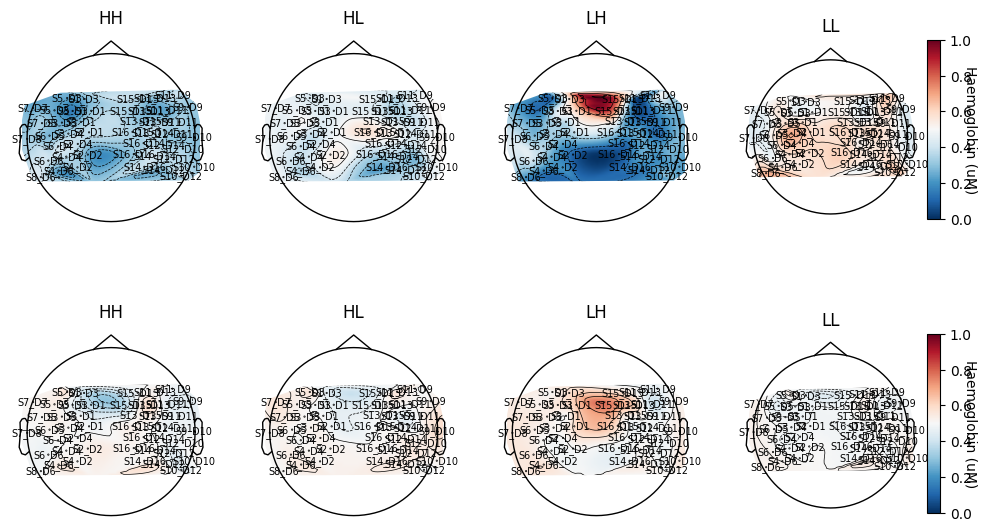

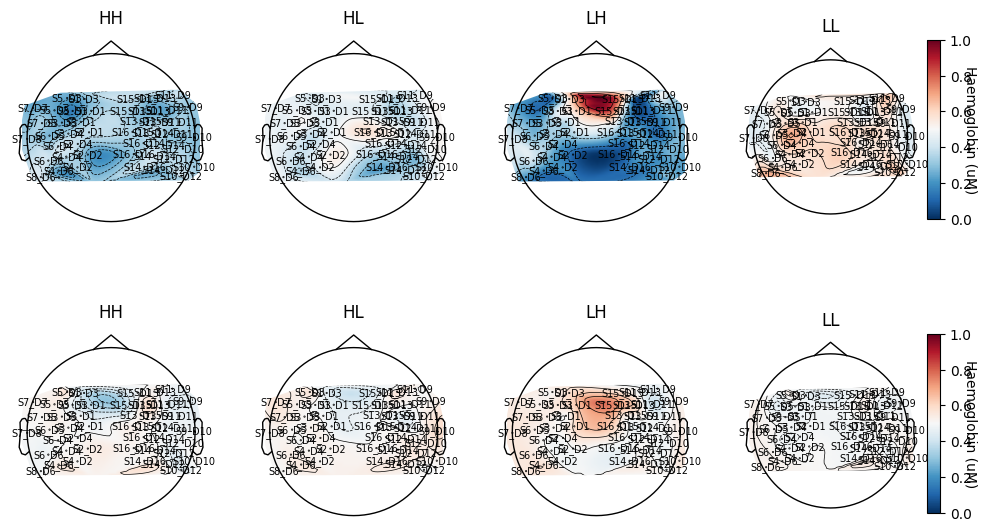

In [ ]:
glm_est.plot_topo(conditions=["HH", "HL", "LH", "LL"])

In [ ]:
dm.columns.tolist()

['HH',
 'HL',
 'LH',
 'LL',
 'drift_1',
 'drift_2',
 'drift_3',
 'drift_4',
 'drift_5',
 'drift_6',
 'drift_7',
 'drift_8',
 'drift_9',
 'drift_10',
 'drift_11',
 'drift_12',
 'drift_13',
 'drift_14',
 'drift_15',
 'drift_16',
 'drift_17',
 'drift_18',
 'drift_19',
 'drift_20',
 'drift_21',
 'drift_22',
 'drift_23',
 'drift_24',
 'drift_25',
 'drift_26',
 'drift_27',
 'drift_28',
 'drift_29',
 'drift_30',
 'drift_31',
 'drift_32',
 'drift_33',
 'drift_34',
 'drift_35',
 'constant']

In [ ]:
import numpy as np

# Build an identity basis over *all* regressors
C = np.eye(dm.shape[1])
basic = {col: C[i] for i, col in enumerate(dm.columns)}

# 2×2 with columns ['HH','HL','LH','LL', ...drifts..., 'constant']
# Main effects (H − L) and interaction (difference of differences)
A_main = 0.5*(basic['HH'] + basic['HL']) - 0.5*(basic['LH'] + basic['LL'])
B_main = 0.5*(basic['HH'] + basic['LH']) - 0.5*(basic['HL'] + basic['LL'])
AxB    = 0.5*(basic['HH'] - basic['HL'] - basic['LH'] + basic['LL'])

# Sanity check: each must be 1D of length = number of columns
for name, v in [('A', A_main), ('B', B_main), ('AxB', AxB)]:
    assert v.ndim == 1 and v.size == dm.shape[1], f"{name} contrast has wrong shape {v.shape}"

# Compute t-contrasts (1 df each; defaults to t for 1D vectors)
con_A   = glm_est.compute_contrast(A_main)
con_B   = glm_est.compute_contrast(B_main)
con_int = glm_est.compute_contrast(AxB)

df_A   = con_A.to_dataframe()
df_B   = con_B.to_dataframe()
df_int = con_int.to_dataframe()


IndexError: invalid index to scalar variable.

IndexError: invalid index to scalar variable.

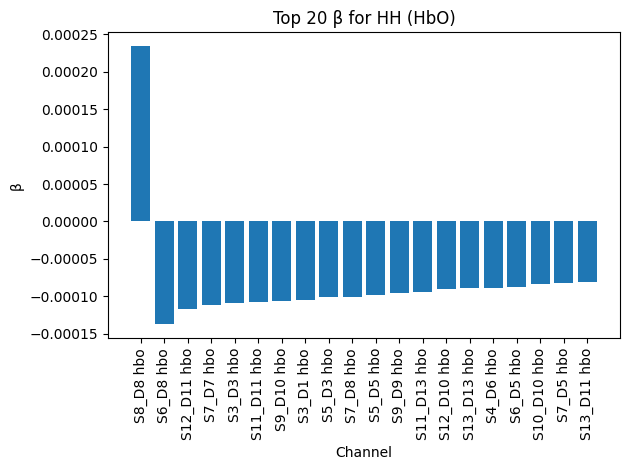

In [ ]:
import matplotlib.pyplot as plt

# pick a condition & hemoglobin
cond = "HH"
mask = (betas_df["regressor"] == cond) & (betas_df["channel"].str.contains("hbo", case=False))
df = betas_df.loc[mask].copy()

# sort by effect size and keep top N (optional)
N = 20
df["absbeta"] = df["beta"].abs()
df = df.sort_values("absbeta", ascending=False).head(N)

plt.figure()
plt.bar(df["channel"], df["beta"])
plt.xticks(rotation=90)
plt.title(f"Top {N} β for {cond} (HbO)")
plt.ylabel("β")
plt.xlabel("Channel")
plt.tight_layout()
plt.show()


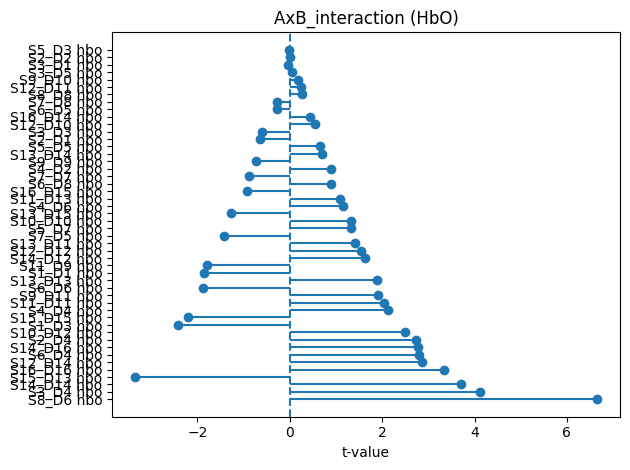

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

con = "AxB_interaction"
mask = (contrast_df["contrast"] == con) & (contrast_df["channel"].str.contains("hbo", case=False))
dfc = (contrast_df.loc[mask]
       .assign(abs_t=lambda d: d["t"].abs())
       .sort_values("abs_t", ascending=False))

plt.figure()
y = np.arange(len(dfc))
plt.hlines(y, 0, dfc["t"])
plt.plot(dfc["t"], y, "o")
plt.yticks(y, dfc["channel"])
plt.axvline(0, linestyle="--")
plt.xlabel("t-value")
plt.title(f"{con} (HbO)")
plt.tight_layout()
plt.show()


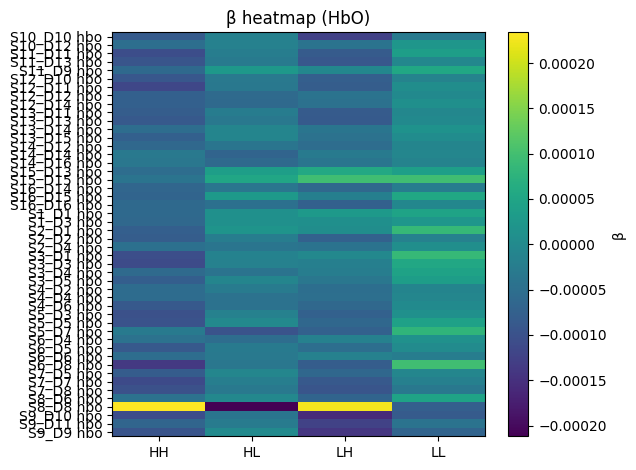

In [ ]:
import matplotlib.pyplot as plt

mask = betas_df["channel"].str.contains("hbo", case=False)
heat = (betas_df.loc[mask]
        .pivot(index="channel", columns="regressor", values="beta")
        .fillna(0.0))

plt.figure()
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="β")
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=0)
plt.title("β heatmap (HbO)")
plt.tight_layout()
plt.show()


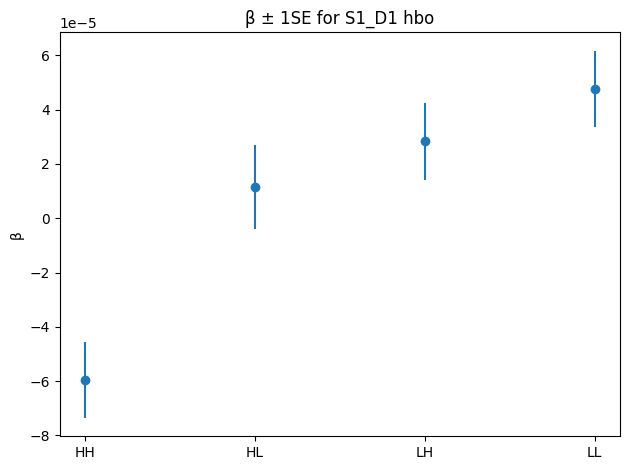

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# choose a single channel to inspect in detail
chan = next(c for c in betas_df["channel"].unique() if "hbo" in c.lower())
row = betas_df[betas_df["channel"] == chan].set_index("regressor").reindex(["HH","HL","LH","LL"])

plt.figure()
x = np.arange(len(row.index))
plt.errorbar(x, row["beta"].values, yerr=row["se"].values, fmt="o")
plt.xticks(x, row.index)
plt.title(f"β ± 1SE for {chan}")
plt.ylabel("β")
plt.tight_layout()
plt.show()


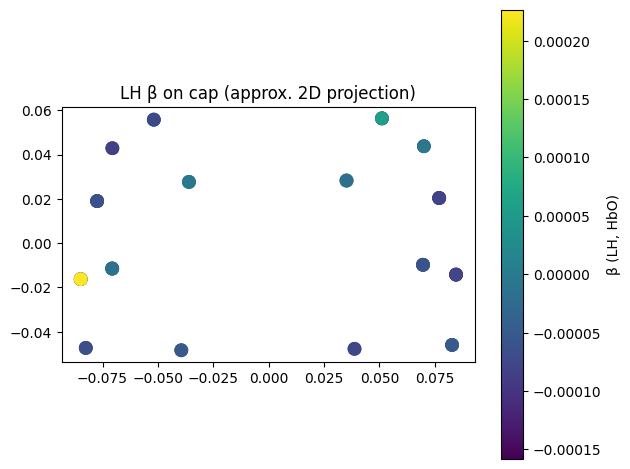

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate per channel for one condition (HbO)
cond = "HH"
df = betas_df[(betas_df["regressor"] == cond) & (betas_df["channel"].str.contains("hbo", case=False))].copy()
beta_map = dict(zip(df["channel"], df["beta"]))

xs, ys, bs, labels = [], [], [], []
for ch in long.info["chs"]:
    name = ch["ch_name"]
    if name in beta_map:
        loc = ch["loc"]  # 12 floats; last 3 are xyz for source, then detector, varies by system
        # try detector position (commonly at indices 6:9) else source (3:6)
        xyz = np.array(loc[6:9]) if np.any(ch["loc"][6:9]) else np.array(loc[3:6])
        if np.any(xyz):
            xs.append(xyz[0]); ys.append(xyz[1])
            bs.append(beta_map[name]); labels.append(name)

if xs:
    plt.figure()
    sc = plt.scatter(xs, ys, s=80, c=bs)
    plt.colorbar(sc, label=f"β ({cond}, HbO)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"{cond} β on cap (approx. 2D projection)")
    plt.tight_layout()
    plt.show()
else:
    print("No channel positions found in info['chs'][i]['loc']; skipping cap plot.")


Used Annotations descriptions: [np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4')]


/tmp/ipython-input-3470447747.py:24: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  fig = plot_design_matrix(design_matrix, ax=ax1)


[(300.0, 1000.0), Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Amplitude')]

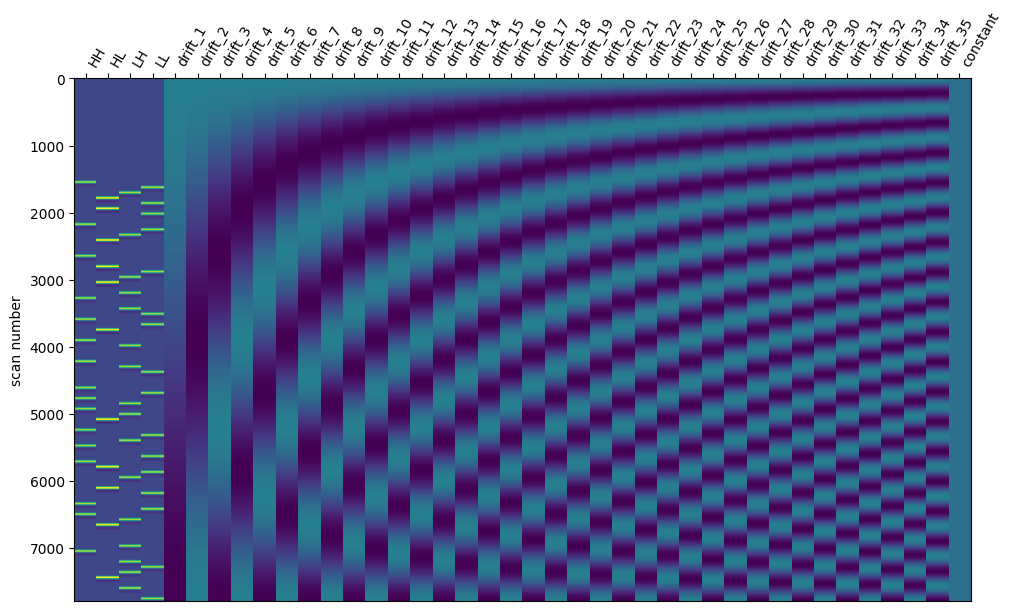

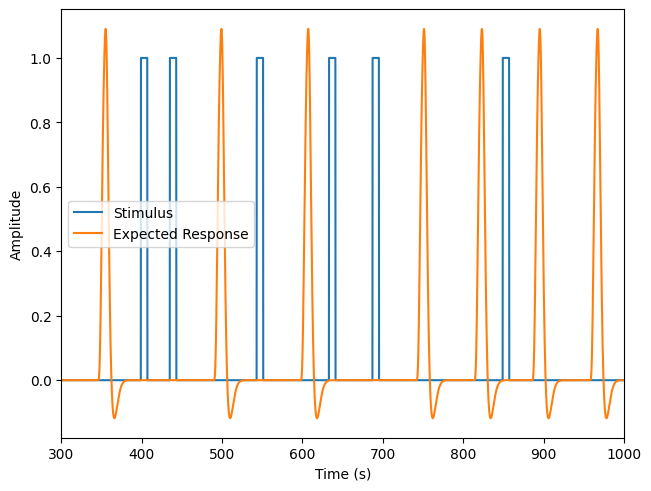

In [ ]:
## GLM with MNE
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
from nilearn.plotting import plot_design_matrix

import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels, picks_pair_to_idx
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
#raw_haemo.annotations.rename({"1": "HH", "2": "HL", "3": "LH", "4": "LL"})

design_matrix = make_first_level_design_matrix(
    raw_haemo,
    drift_model="cosine",
    high_pass=0.01,  # Must be specified per experiment
    hrf_model="spm",
    stim_dur=8.0,
)

fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)

fig, ax = plt.subplots(constrained_layout=True)
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=8.0)
ax.plot(raw_haemo.times, s[:, 1])
ax.plot(design_matrix["HH"])
ax.legend(["Stimulus", "Expected Response"])
ax.set(xlim=(300, 1000), xlabel="Time (s)", ylabel="Amplitude")



In [ ]:
raw_clean = raw_haemo.copy().drop_channels(bad_chs)   # remove bad channels
long_clean = get_long_channels(raw_clean)
glm_est = run_glm(long_clean, design_matrix)

<Axes: xlabel='Condition', ylabel='Theta'>

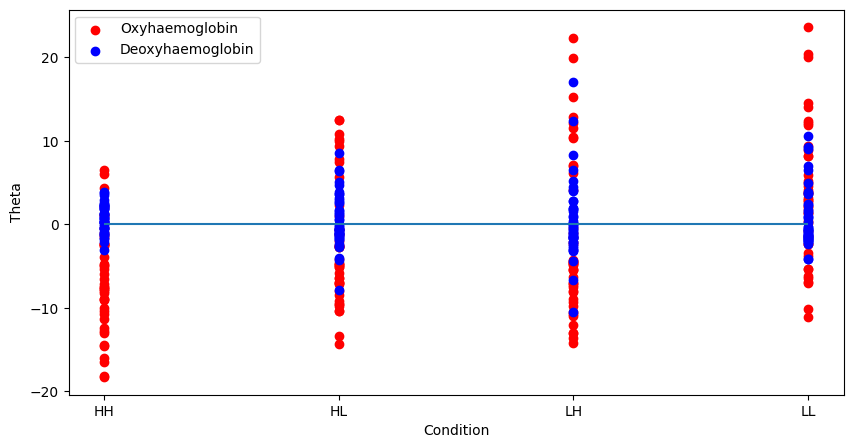

In [ ]:
glm_est.scatter()

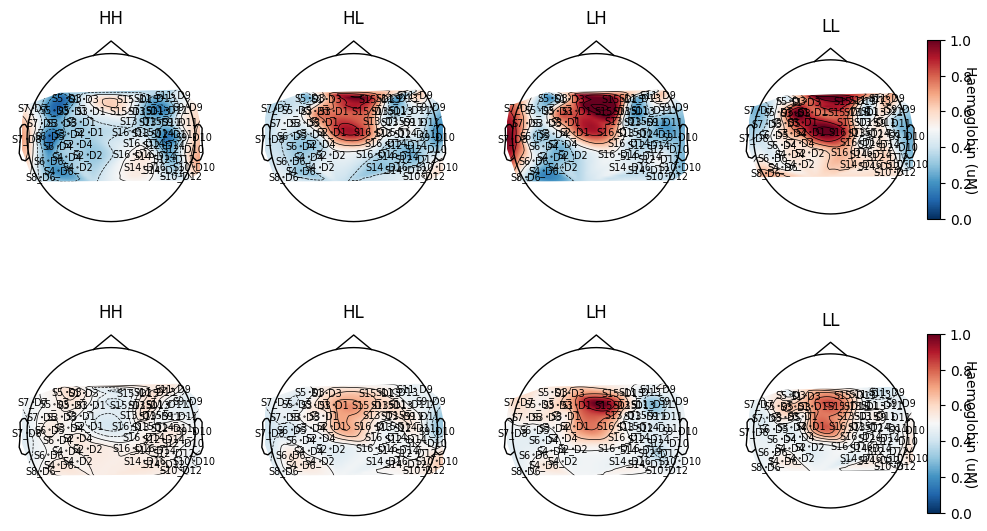

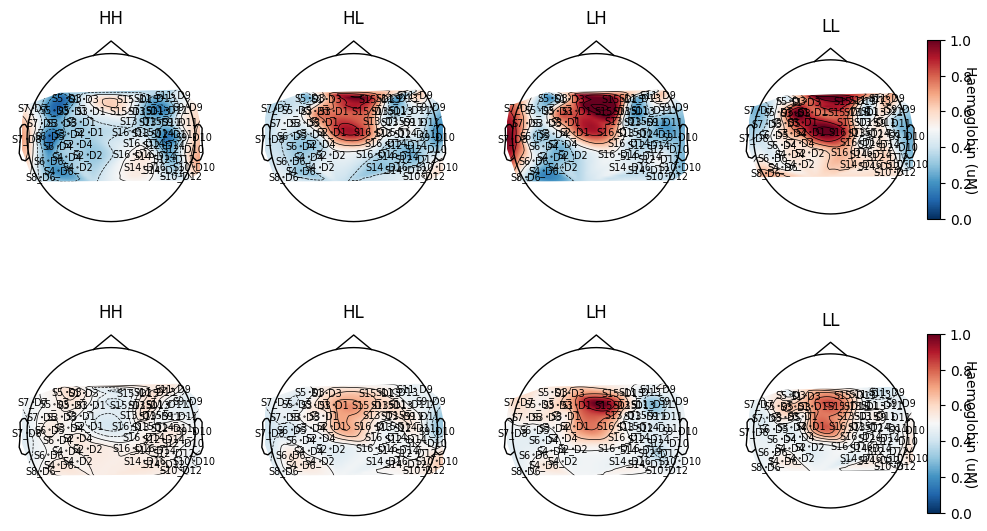

In [ ]:

glm_est.plot_topo(conditions=["HH", "HL", "LH", "LL"])

IndexError: invalid index to scalar variable.

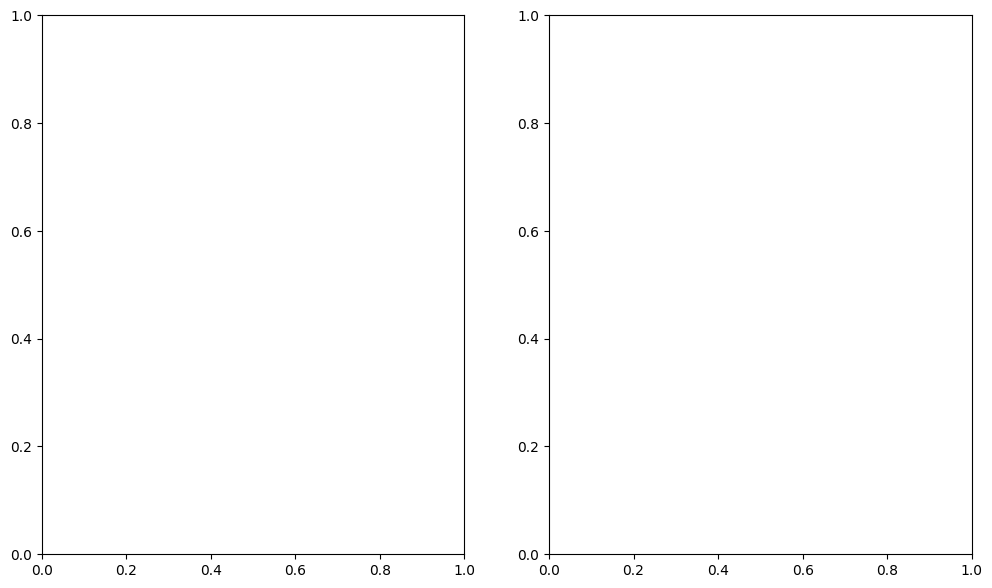

In [ ]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_conts = dict(
    [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)]
)
contrast_LvR = basic_conts["LH"] - basic_conts["HH"]

contrast = glm_est.compute_contrast(contrast_LvR)
contrast.plot_topo()

In [ ]:
betas_df.to_csv("betas.csv", index=False)
contrast_df.to_csv("contrasts.csv", index=False)


Not setting metadata
59 matching events found
Setting baseline interval to [-5.046271999999999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 59 events and 58 original time points ...
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S9_D9 hbo', 'S15_D13 hbo', 'S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S2_D2 hbo', 'S11_D11 hbo', 'S11_D13 hbo', 'S13_D13 hbo', 'S15_D13 hbo', 'S15_D15 hbo', 'S16_D16 hbo']
    Rejecting  epoch based on HBO : ['S2_D4 hbo', 'S3_D1 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D4 hbo', 'S5_D3 hbo', 'S5_D5 hbo', 'S6_D5 hbo', 'S6_D6 hbo', 'S7_D7 hbo', 'S9_D9 hbo', 'S9_D10 hbo', 'S9_D11 hbo', 'S10_D10 hbo', 'S11_D9 hbo', 'S11_D11 hbo', 'S11_D13 hbo', 'S12_D10 hbo', 'S12_D11 hbo', 'S12_D12 hbo', 'S13_D11 hbo', 'S16_D16 hbo']
    Rejecting  epoch based on HBO : ['S7_D7 hbo', 'S9_D9 hbo', 'S9_D10 hbo', 'S9_D11 hbo']
    Rejecting  epoch based on HBO : ['S2_D2 hbo', 'S14_D16 hbo', 'S16_D16 hbo']
    

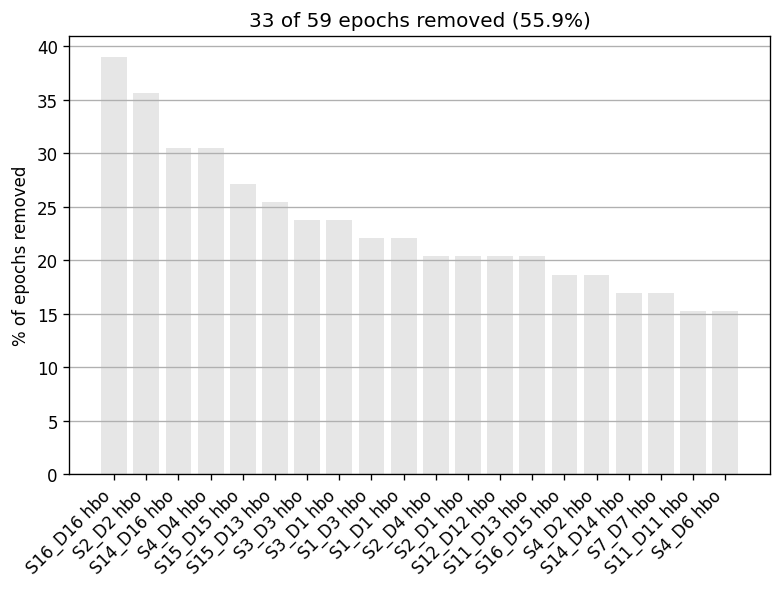

Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


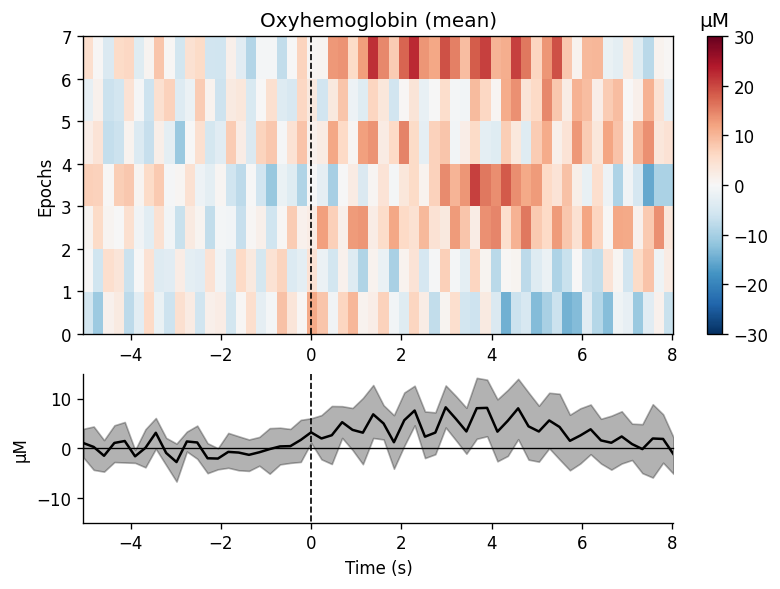

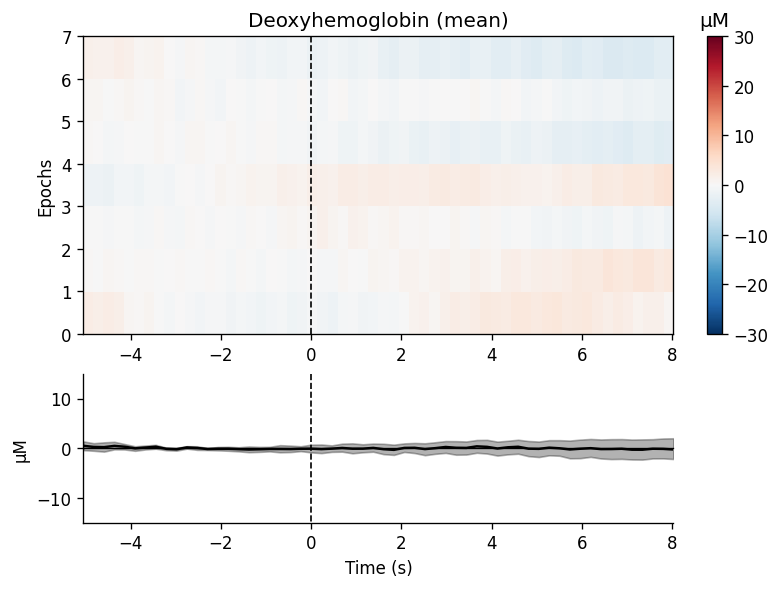

[<Figure size 768x576 with 3 Axes>, <Figure size 768x576 with 3 Axes>]

In [ ]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 8

epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)
epochs.plot_drop_log()

epochs["GR4"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


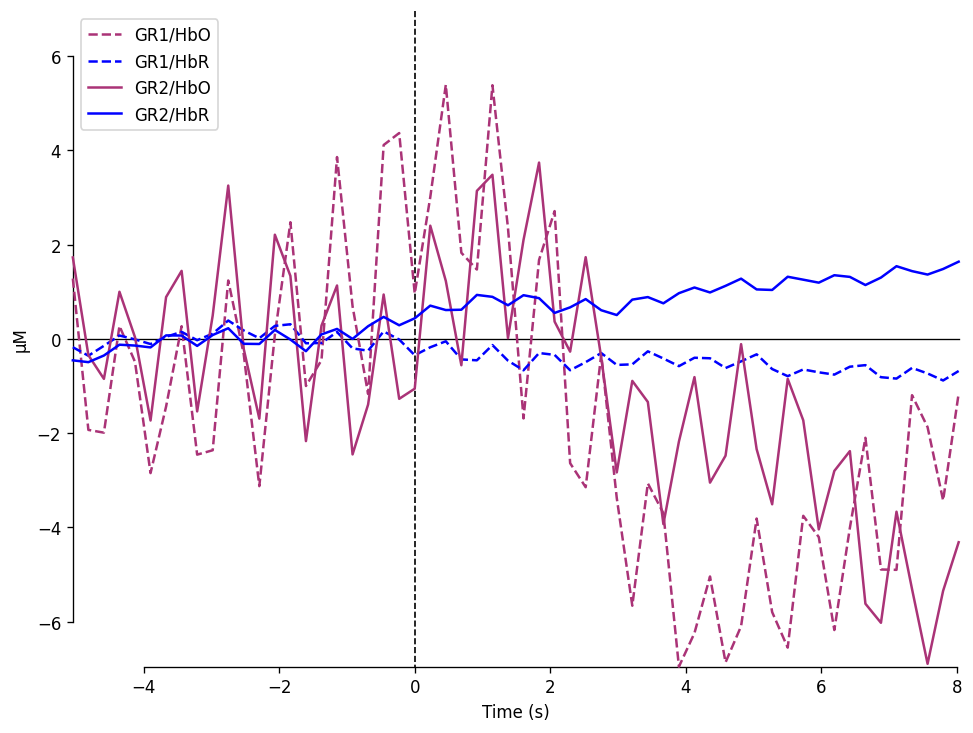

[<Figure size 960x720 with 1 Axes>]

In [ ]:
evoked_dict = {
    "GR1/HbO": epochs["GR1"].average(picks="hbo"),
    "GR1/HbR": epochs["GR1"].average(picks="hbr"),
    "GR2/HbO": epochs["GR2"].average(picks="hbo"),
    "GR2/HbR": epochs["GR2"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(GR1=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

In [ ]:
# 1) Load raw SNIRF
raw_intensity = mne.io.read_raw_snirf(snirf_file, preload=True)

import numpy as np
import mne

keepers = {"1", "2", "3", "4"}

onset   = raw_intensity.annotations.onset
duration = raw_intensity.annotations.duration
desc     = raw_intensity.annotations.description

# Select only conditions 1–4
mask = np.array([d in keepers for d in desc])
onset_sel, duration_sel, desc_sel = onset[mask], duration[mask], desc[mask]

# Now keep only the first of each consecutive pair
keep_indices = []
for i, d in enumerate(desc_sel):
    if i == 0 or d != desc_sel[i-1]:
        keep_indices.append(i)

onset_final   = onset_sel[keep_indices]
duration_final = duration_sel[keep_indices]
desc_final     = desc_sel[keep_indices]

# Replace annotations with cleaned ones
raw_intensity.set_annotations(
    mne.Annotations(onset=onset_final, duration=duration_final, description=desc_final)
)


ann_df = raw_intensity.annotations.to_data_frame()
print(ann_df.to_string())  # prints full DataFrame without truncation

Loading /content/drive/MyDrive/04_Students/MSc_Students/2024_Iva_Savic/fNIRS_Laila_Iva2025/2025-05-02_001/2025-05-02_001.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 7784  =      0.000 ...  1785.463 secs...
                        onset  duration description
0  2025-05-02 10:04:21.202186      10.0           1
1  2025-05-02 10:04:39.206595      10.0           4
2  2025-05-02 10:04:57.198020      10.0           3
3  2025-05-02 10:05:15.193570      10.0           2
4  2025-05-02 10:05:33.190364      10.0           4
5  2025-05-02 10:05:51.185272      10.0           2
6  2025-05-02 10:06:09.190211      10.0           4
7  2025-05-02 10:06:45.182847      10.0           1
8  2025-05-02 10:07:03.184531      10.0           4
9  2025-05-02 10:07:21.200377      10.0           3
10 2025-05-02 10:07:39.188577      10.0           2
11 2025-05-02 10:08:33.189499      10.0           1
12 2025-05-02 10:09:09.188059      10.0           2
13 2025-05-02 10:09:27.193795      10.0        

In [ ]:

# 2) Annotations: rename, set 5 s durations, drop code '15'
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename({"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"})
to_drop = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(to_drop)

# 3) (Optional) Visual check of montage on fsaverage (see tutorial)

# 4) Keep long-sep channels (> 1 cm)
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_intensity.info, picks=picks)
raw_intensity.pick(picks[dists > 0.01])

# 5) Intensity -> Optical Density
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


# 6) SCI QC: mark bads if desired
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
##I added this
fig, ax = plt.subplots(layout="constrained")
ax.hist(sci); ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])

bads = list(compress(raw_od.ch_names, sci < 0.8))   # <- define OD bads here
raw_od.info["bads"] = bads
bad_bases = {ch.split()[0] for ch in bads}          # <- base names like "S1_D1"
##till here
#raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))  # threshold per tutorial example

# 7) OD -> HbO/HbR (PPF example shown in the tutorial)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
##I added this
# Map OD bads to Hb-space names and drop them
bad_chs = [f"{b} hbo" for b in bad_bases] + [f"{b} hbr" for b in bad_bases]
bad_chs = [ch for ch in bad_chs if ch in raw_haemo.ch_names]
if bad_chs:
    raw_haemo.drop_channels(bad_chs)
##till her
# 8) Filter (remove cardiac ~1 Hz, remove slow drifts)
raw_haemo = raw_haemo.filter(l_freq=0.01, h_freq=0.5)  # choose exact cutoffs per your study design

# 9) Epoch per condition
events, event_id = mne.events_from_annotations(raw_haemo)
epochs = mne.Epochs(raw_haemo, events, event_id=event_id,
                    tmin=-5, tmax=15, baseline=(None, 0), preload=True)

# 10) Average/visualize as needed
evoked_hbo = epochs["Tapping"].average(picks="hbo")
evoked_hbr = epochs["Tapping"].average(picks="hbr")


ValueError: Invalid Annotation description(s) {'3.0', '1.0', '2.0'} are not present in data

In [ ]:
import mne
import numpy as np
from itertools import compress
import matplotlib.pyplot as plt
from pathlib import Path

# ----------- CONFIG -------------
folder = Path("/2025-05-02_001")   # <-- change to your folder
snirf_file = list(folder.glob("*.snirf"))[0]
report_file = folder / "QC_report.txt"
# --------------------------------

# 1) Load raw SNIRF
raw_intensity = mne.io.read_raw_snirf(snirf_file, preload=True)

# 2) Convert to Optical Density
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

# 3) Compute Scalp Coupling Index
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
bad_channels = list(compress(raw_od.ch_names, sci < 0.5))
raw_od.info["bads"].extend(bad_channels)

# 4) Convert OD -> haemoglobin (HbO/HbR) using Beer-Lambert
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

# 5) Band-pass filter (remove drifts & heartbeat)
raw_haemo.filter(l_freq=0.01, h_freq=0.5)

# ----------- SAVE QC REPORT -------------
with open(report_file, "w") as f:
    f.write(f"Quality Control Report for {snirf_file.name}\n")
    f.write("="*60 + "\n\n")
    f.write(f"Number of channels: {len(raw_haemo.ch_names)}\n")
    f.write(f"Bad channels (SCI < 0.5): {bad_channels}\n")
    f.write("\nScalp Coupling Index (all channels):\n")
    for ch, val in zip(raw_od.ch_names, sci):
        f.write(f"{ch}: {val:.2f}\n")
    f.write("\nImages saved in this folder:\n")
    f.write(" - raw_haemo_cleaned.png (clean HbO/HbR time series)\n")
    f.write(" - sci_distribution.png (histogram of SCI values)\n")

# ----------- SAVE IMAGES -------------
# Plot cleaned HbO/HbR signals
raw_haemo.plot(n_channels=10, duration=200, show=False)  # adapt duration/channels
plt.savefig(folder / "raw_haemo_cleaned.png")
plt.close()

# Plot distribution of SCI
plt.figure()
plt.hist(sci, bins=20)
plt.axvline(0.5, color="r", linestyle="--", label="SCI threshold")
plt.xlabel("Scalp Coupling Index")
plt.ylabel("Count")
plt.legend()
plt.title("SCI Distribution")
plt.savefig(folder / "sci_distribution.png")
plt.close()

print(f"QC report written to {report_file}")

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip -q install "numpy<2.2" "pandas==2.2.2" "mne>=1.7,<2.0" "mne-nirs>=0.7" "matplotlib<3.9"\nprint("Installed pinned versions. If NumPy changed, please restart the runtime (Runtime > Restart session) and rerun from here.")'
Reading SNIRF: /content/drive/MyDrive/04_Students/MSc_Students/2024_Iva_Savic/fNIRS_Laila_Iva2025/2025-05-02_001/2025-05-02_001.snirf


RuntimeError: Scalp coupling index must operate on optical density data, but none was found.